In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
import itertools
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict
from pandas.plotting import parallel_coordinates
# from PSSimPy.simulator import ABMSim
from PSSimPy import Bank, Account
from PSSimPy.credit_facilities import SimpleCollateralized, AbstractCreditFacility
from PSSimPy.utils import add_minutes_to_time, minutes_between

from MDP import MechMDPSearch, OriMDPSearch, MDPStateExt, MDPState
from SimClasses import ABMSim

# Classes

## Custom Credit Facility
Credit facility has the ability to provide credit through three means:
1. Accepting traditional collateral
2. Accepting incoming transactions as collateral
3. Providing unsecured credit

In [1]:
class CollateralizedCreditFacility(AbstractCreditFacility):
    def __init__(self, collateralized_transactions=None, gamma=0.6, phi=0.5, chi=0.75):
        AbstractCreditFacility.__init__(self)
        self.collateralized_transactions = collateralized_transactions if collateralized_transactions is not None else {}
        self.gamma = gamma  # traditional borrowing cost
        self.phi = phi      # pledged-collateral borrowing cost
        self.chi = chi      # unsecured borrowing cost
        # Track credit issued: account.id -> list of tuples (credit_type, amount)
        self.used_credit = {}
        self.history = {}

    def lend_credit(self, account, amount: float) -> None:
        """
        Issue credit to *account* for *amount* according to the rules below.
        ──────────────────────────────────────────────────────────────────────────
        γ  : marginal cost of credit secured by posted collateral
        φ  : marginal cost of credit secured by incoming transactions
        χ  : marginal cost of unsecured credit

        1. If χ is the lowest of {γ, φ, χ}: lend the full *amount* unsecured.

        2. If account.posted_collateral ≥ amount (i.e. collateral is sufficient):
        2a. If φ < χ, first exhaust every valid incoming transaction (status_code
            == 0 and not yet pledged) as collateral, looping until either no
            valid txns remain or credit need is met.
        2b. Use posted collateral for any remainder (or the whole amount if
            φ ≥ χ).

        3. If account.posted_collateral < amount (i.e. collateral is insufficient):
        3a. If χ < φ, lend the full *amount* unsecured.
        3b. Else, first exhaust valid incoming transactions as collateral.
            If credit is still needed, lend the balance unsecured.

        Every tranche advanced is logged in
        self.used_credit[account.id]  →  List[Tuple[str, float, *extra*]]
        so later cost calculations can distinguish ‘unsecured’,
        ‘collateralized_txn’, and ‘collateralized_posted’.
        ──────────────────────────────────────────────────────────────────────────
        """

        # ────────────────────── internal helpers ──────────────────────────
        def _record(kind: str, qty: float, ref=None):
            self.used_credit.setdefault(account.id, []).append((kind, qty, ref))

        def _issue_unsecured(qty: float) -> float:
            if qty > 0:
                account.balance += qty
                _record("unsecured", qty)
            return 0.0

        def _use_posted_collateral(qty: float) -> float:
            take = min(qty, account.posted_collateral)
            if take > 0:
                account.posted_collateral -= take
                account.balance += take
                _record("collateralized_posted", take)
            return qty - take

        def _use_incoming_txn_collateral(qty: float) -> float:
            if qty <= 0:
                return 0.0
            # all un‑pledged, settled‑status incoming txns, largest first
            valid = [
                t for t in account.txn_in
                if t.status_code == 0
                and t not in self.collateralized_transactions.get(account.id, set())
            ]
            valid.sort(key=lambda t: t.amount, reverse=True)

            for txn in valid:
                if qty == 0:
                    break
                take = min(qty, txn.amount)
                self.collateralized_transactions.setdefault(account.id, set()).add(txn)
                account.balance += take
                _record("collateralized_txn", take, txn)
                qty -= take
            return qty
        # ────────────────── end helpers ───────────────────────────────

        remaining = amount

        # Rule 1 ─ unsecured is globally cheapest
        if self.chi < self.gamma and self.chi < self.phi:
            _issue_unsecured(remaining)
            return

        # Rule 2 ─ posted collateral is at least as large as the need
        if account.posted_collateral >= remaining:
            if self.phi < self.chi:
                remaining = _use_incoming_txn_collateral(remaining)
            remaining = _use_posted_collateral(remaining)
            # The branch guarantees sufficiency, but belt‑and‑braces:
            if remaining:
                _issue_unsecured(remaining)
            return

        # Rule 3 ─ posted collateral is insufficient
        if self.chi < self.phi:
            _issue_unsecured(remaining)
            return

        # Prefer incoming‑txn collateral first, then unsecured for any leftover
        remaining = _use_incoming_txn_collateral(remaining)
        _issue_unsecured(remaining)

    def collect_all_repayment(self, day: int, accounts: List[Account]) -> None:
        """
        Collect repayments from all accounts.
        """
        for account in accounts:
            self.history.setdefault(account.id, []).append(
                (day, self.get_total_credit(account), self.get_total_fee(account))
            )
            self.collect_repayment(account)

    def calculate_fee(self, credit_amount, credit_type) -> float:
        """
        Calculate the fee for a given credit amount based on its type.
        
        - For 'collateralized_posted', fee = gamma * credit_amount.
        - For 'collateralized_txn', fee = phi * credit_amount.
        - For 'unsecured', fee = chi * credit_amount.
        """
        if credit_type == 'collateralized_posted':
            return self.gamma * credit_amount
        elif credit_type == 'collateralized_txn':
            return self.phi * credit_amount
        elif credit_type == 'unsecured':
            return self.chi * credit_amount
        else:
            return 0.0


    def collect_repayment(self, account) -> None:
        # Not implemented for now.
        pass

    def get_total_credit(self, account: Account) -> float:
        """
        Return the aggregate amount of credit issued to *account*,
        independent of credit source.  Works even if each log entry
        carries extra metadata.
        """
        return sum(entry[1] for entry in self.used_credit.get(account.id, []))

    def get_total_fee(self, account: Account) -> float:
        """
        Sum all fees owed by *account* based on the credit tranches logged
        in self.used_credit.  Works whether each log entry is
        (ctype, amount)
        or
        (ctype, amount, extra_metadata).
        """
        total_fee = 0.0
        for entry in self.used_credit.get(account.id, []):
            credit_type = entry[0]      # always first element
            amount      = entry[1]      # always second element
            total_fee  += self.calculate_fee(
                credit_amount=amount,
                credit_type=credit_type
            )
        return total_fee

    
    def get_total_credit_and_fee(self, account: Account) -> float:
        """
        Obtain the total credit and fee for an account.
        """
        return self.get_total_credit(account) + self.get_total_fee(account)

NameError: name 'AbstractCreditFacility' is not defined

## Bank Strategy

In [ ]:
mdp = MechMDPSearch(n_players=10, n_periods=10, p_t=1, delta=0.1, delta_prime=0.9, gamma=0.15, phi=0.25, chi=0.35, seed=1000)

In [ ]:
class MechStrategicBank(Bank):
    def __init__(self, name, strategy_type='MechStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)
        self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
        self.mdp_previous_action = 0
        self.n_periods = 10
    
    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        if len(txns_to_settle) == 0:
            return set()
        else:
            # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
            txn = txns_to_settle.copy().pop()
            bank_account = txn.sender_account

        # calculate amount of obligations that arrived in this period
        arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
        # calculate the amount of claims that arrived in this current period
        observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

        if current_time == "08:00":
            partial_obs = {
                "inbound_payments": 0,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
        else:
            # calculate actual inbound payments from previous period
            previous_time = add_minutes_to_time(current_time, -15)
            df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
            filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                    (df_processed_txns['settlement_time'] == previous_time)]
            inbound_payments = filtered_df['amount'].sum()

            partial_obs = {
                "inbound_payments": inbound_payments,
                "arrived_obligations": arrived_obligations,
                "observed_claims": observed_claims,
                "observed_expected": 0.75  # not used when ζ = 0
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

        _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
        self.n_periods -= 1
        self.mdp_previous_action = best_act

        if best_act == 1:
            return txns_to_settle
        else:
            return set()

In [ ]:
class RandomBank(Bank):
    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)

    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        r = random.randint(0, 1)
        if r == 1:
            return txns_to_settle
        else:
            return set()

# Helper Functions

In [ ]:
def calculate_delay_cost(sim_name, account: str, delta: float, delta_prime: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * (delta + delta_prime)
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [ ]:
def calculate_borrowing_cost(sim_name, account: str):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowing_cost = row['total_fee']
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

In [ ]:
def calculate_average_payment_delay(sim_name, account: str):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]

    txn_delays = []
    for _, row in relevant_txns.iterrows():
        arrival_time = row['time']
        submission_time = row['submission_time']
        delay = minutes_between(arrival_time, submission_time)/15 # normalized to periods
        txn_delays.append(delay)

    return float(np.mean(txn_delays))

In [ ]:
def visualize_single_cost_distribution(total_costs: list, label="Scenario", title='Total Cost Distribution'):
    # Convert to numpy array
    costs = np.array(total_costs)

    # Compute summary statistics
    mean_cost = np.mean(costs)
    median_cost = np.median(costs)
    std_cost = np.std(costs)

    # Print summary statistics
    print(f"{label}:")
    print("Mean total cost:", mean_cost)
    print("Median total cost:", median_cost)
    print("Standard Deviation:", std_cost)
    print("")

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(costs, bins='auto', density=True, alpha=0.6, color='steelblue', edgecolor='black', label=label)

    # Overlay the mean and median as vertical lines
    plt.axvline(mean_cost, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_cost:.2f}')
    plt.axvline(median_cost, color='navy', linestyle='dotted', linewidth=2, label=f'Median: {median_cost:.2f}')

    # Labeling
    plt.title(title)
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.show()

# Simulation

In [ ]:
def simulate_mech_game(p_t: float, delta: float, gamma: float, delta_prime: float, phi: float, chi: float, seed: int, focal_account='acc3', strategic_template=1):
    mdp = MechMDPSearch(
        n_players=3,
        n_periods=10,
        p_t=p_t,
        delta=delta,
        delta_prime=delta_prime,
        gamma=gamma,
        phi=phi,
        chi=chi,
        seed=seed
    )

    # redefine strategic bank
    # Set up strategic bank agent
    class MechStrategicBank(Bank):
        def __init__(self, name, strategy_type='MechStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 10
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
            # calculate the amount of claims that arrived in this current period
            observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

            if current_time == "08:00":
                partial_obs = {
                    "inbound_payments": 0,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()
        
    strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
    collateralized_credit_facility = CollateralizedCreditFacility(gamma=gamma, phi=phi, chi=chi)

    # strategic play
    if strategic_template == 1:
        banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
    elif strategic_template == 2:
        banks = pd.read_csv('data_input/bank_template_with_mech_strategy_all.csv')
    # elif strategic_template == 3:
    #     banks = pd.read_csv('data_input/bank_template_with_strategy_2.csv')
    # else:
    #     banks = pd.read_csv('data_input/bank_template.csv')
    accounts = pd.read_csv('data_input/account_template_with_collateral.csv')
    sim_name = 'test_sim'
    sim = ABMSim(name=sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=p_t, txn_amount_range=(1,1))
    sim.run()
    
    # extract costs
    delay_costs = {}
    borrowing_costs = {}
    average_payment_delays = {}
    for account in accounts['id'].tolist():
        delay_costs[account] = calculate_delay_cost(sim_name, account, delta, delta_prime)
        borrowing_costs[account] = calculate_borrowing_cost(sim_name, account)

        average_payment_delays[account] = calculate_average_payment_delay(sim_name, account)

    # tear down
    # Remove each .csv file
    csv_files = glob.glob("*.csv")
    for file in csv_files:
        os.remove(file)

    # need to consider costs of focal account and system as a whole (to cater for welfare)
    return {'total_costs_to_player': delay_costs[focal_account] + borrowing_costs[focal_account], 
            'total_costs': sum([delay_costs[account] + borrowing_costs[account] for account in accounts['id'].tolist()]), 
            'average_payment_delay_of_player': average_payment_delays[focal_account],
            'average_payment_delay': sum([average_payment_delays[account] for account in accounts['id'].tolist()])}

In [ ]:
banks = pd.read_csv('data_input/bank_template_with_mech_strategy.csv')
accounts = pd.read_csv('data_input/account_template_with_collateral.csv')

strategy_mapping = {'Strategic': MechStrategicBank, 'Random': RandomBank}
collateralized_credit_facility = CollateralizedCreditFacility(gamma=0.2, phi=0.3, chi=0.5)

sim = ABMSim(name='test_sim', banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
sim.run()

In [ ]:
p_t = 0.8
delta = 0.0
gamma = 0.1
n_simulations = 10

param_values = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

# Loop over all combinations of delta_prime, phi, chi
for delta_prime, phi, chi in itertools.product(param_values, repeat=3):
    total_costs = []
    total_costs_to_player = []
    average_payment_delays = []
    average_payment_delays_of_player = []

    for sim_seed in range(1000, 1000 + n_simulations):
        random.seed(sim_seed)
        np.random.seed(sim_seed)
        
        sim_output = simulate_mech_game(p_t, delta, gamma, delta_prime, phi, chi, sim_seed)
        total_cost_to_player = sim_output['total_costs_to_player']
        total_cost = sim_output['total_costs']
        average_payment_delay = sim_output['average_payment_delay']
        average_payment_daly_of_player = sim_output['average_payment_delay_of_player']
        
        total_costs_to_player.append(total_cost_to_player)
        total_costs.append(total_cost)
        average_payment_delays.append(average_payment_delay)
        average_payment_delays_of_player.append(average_payment_daly_of_player)

    # Store average results for each combination
    results.append({
        'delta_prime': delta_prime,
        'phi': phi,
        'chi': chi,
        'avg_total_cost': np.mean(total_costs),
        'avg_total_cost_to_player': np.mean(total_costs_to_player),
        'avg_payment_delay': np.mean(average_payment_delays),
        'avg_payment_delay_of_player': np.mean(average_payment_delays_of_player)
    })

Scenario:
Mean total cost: 39.287
Median total cost: 37.35
Standard Deviation: 12.80041136057744



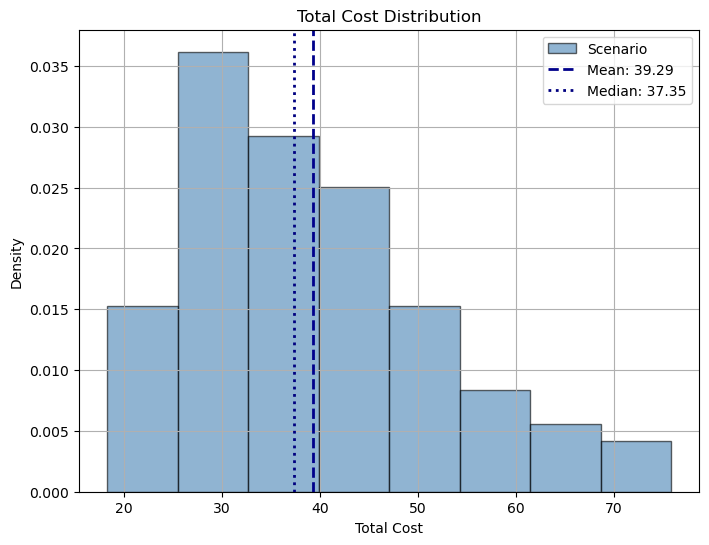

In [ ]:
visualize_single_cost_distribution(total_costs)

KeyError: 'avg_payment_delay'

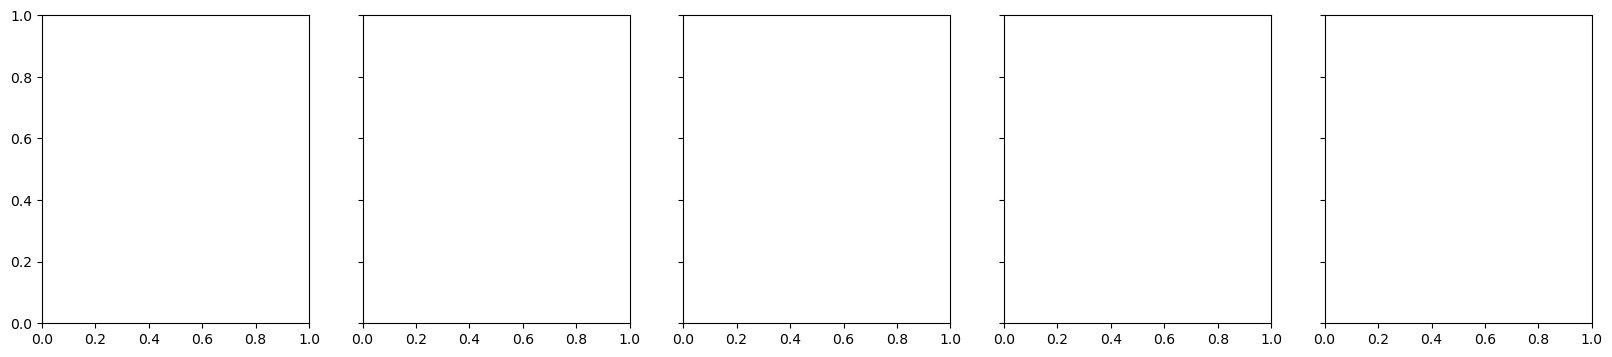

In [ ]:
df = pd.DataFrame(results)

# Round to make the heatmap display cleaner
df['delta_prime'] = df['delta_prime'].round(2)
df['phi'] = df['phi'].round(2)
df['chi'] = df['chi'].round(2)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
chi_values = sorted(df['chi'].unique())

for i, chi_val in enumerate(chi_values):
    subset = df[df['chi'] == chi_val]
    pivot_delay = subset.pivot(index='phi', columns='delta_prime', values='avg_payment_delay_of_player')
    pivot_cost = subset.pivot(index='phi', columns='delta_prime', values='avg_total_cost_to_player')

    sns.heatmap(pivot_delay, annot=pivot_cost.round(1), fmt=".1f", cmap="YlGnBu", ax=axes[i],
                cbar=i == 4, cbar_kws={'label': 'Avg Payment Delay'} if i == 4 else None)
    
    axes[i].set_title(f'chi = {chi_val}')
    axes[i].set_xlabel("delta_prime")
    if i == 0:
        axes[i].set_ylabel("phi")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Heatmaps of a Strategic Player's Avg Delay (color) and Avg Cost (annotated) by Parameter Combinations", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### All Strategic

In [ ]:
p_t = 0.8
delta = 0.0
gamma = 0.1
n_simulations = 10

param_values = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

# Loop over all combinations of delta_prime, phi, chi
for delta_prime, phi, chi in itertools.product(param_values, repeat=3):
    total_costs = []
    total_costs_to_player = []
    average_payment_delays = []
    average_payment_delays_of_player = []

    for sim_seed in range(1000, 1000 + n_simulations):
        random.seed(sim_seed)
        np.random.seed(sim_seed)
        
        sim_output = simulate_mech_game(p_t, delta, gamma, delta_prime, phi, chi, sim_seed, strategic_template=2)
        total_cost_to_player = sim_output['total_costs_to_player']
        total_cost = sim_output['total_costs']
        average_payment_delay = sim_output['average_payment_delay']
        average_payment_daly_of_player = sim_output['average_payment_delay_of_player']
        
        total_costs_to_player.append(total_cost_to_player)
        total_costs.append(total_cost)
        average_payment_delays.append(average_payment_delay)
        average_payment_delays_of_player.append(average_payment_daly_of_player)

    # Store average results for each combination
    results.append({
        'delta_prime': delta_prime,
        'phi': phi,
        'chi': chi,
        'avg_total_cost': np.mean(total_costs),
        'avg_total_cost_to_player': np.mean(total_costs_to_player),
        'avg_payment_delay': np.mean(average_payment_delays),
        'avg_payment_delay_of_player': np.mean(average_payment_delays_of_player)
    })

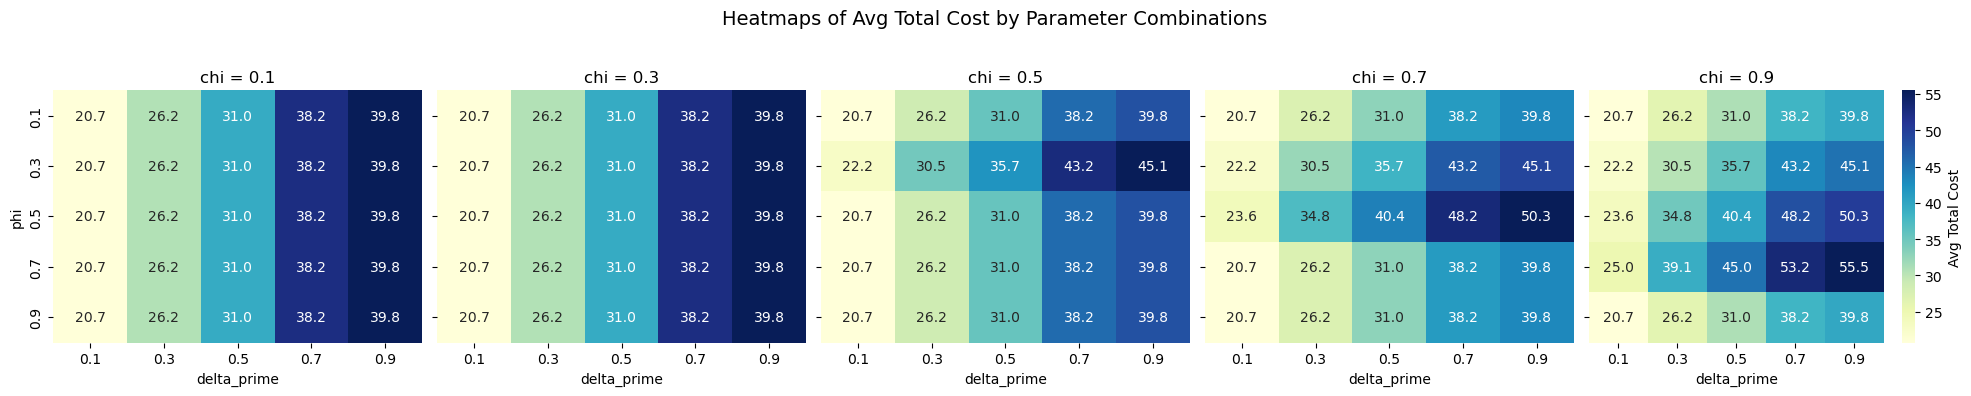

In [ ]:
df = pd.DataFrame(results)

# Round to make the heatmap display cleaner
df['delta_prime'] = df['delta_prime'].round(2)
df['phi'] = df['phi'].round(2)
df['chi'] = df['chi'].round(2)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
chi_values = sorted(df['chi'].unique())

for i, chi_val in enumerate(chi_values):
    subset = df[df['chi'] == chi_val]
    pivot_delay = subset.pivot(index='phi', columns='delta_prime', values='avg_payment_delay')
    pivot_cost = subset.pivot(index='phi', columns='delta_prime', values='avg_total_cost')

    sns.heatmap(pivot_delay, annot=pivot_cost.round(1), fmt=".1f", cmap="YlGnBu", ax=axes[i],
                cbar=i == 4, cbar_kws={'label': 'Avg Total Cost'} if i == 4 else None)
    
    axes[i].set_title(f'chi = {chi_val}')
    axes[i].set_xlabel("delta_prime")
    if i == 0:
        axes[i].set_ylabel("phi")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Heatmaps of System Avg Delay (color) and Avg Cost (annotated) by Parameter Combinations", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()